# total

Epoch 1/100
42/42 [==============================] - 3s 12ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/100
42/42 [==============================] - 0s 5ms/step - loss: 9.7521e-04 - val_loss: 0.0010
Epoch 5/100
42/42 [==============================] - 0s 5ms/step - loss: 9.7589e-04 - val_loss: 0.0010
Epoch 6/100
42/42 [==============================] - 0s 5ms/step - loss: 9.7885e-04 - val_loss: 0.0010
Epoch 7/100
42/42 [==============================] - 0s 5ms/step - loss: 9.4873e-04 - val_loss: 0.0010
Epoch 8/100
42/42 [==============================] - 0s 5ms/step - loss: 9.4199e-04 - val_loss: 9.9579e-04
Epoch 9/100
42/42 [==============================] - 0s 5ms/step - loss: 9.6679e-04 - val_loss: 0.0011
Epoch 10/100
42/42 [==============================] - 0s 5ms/step - loss: 9.2784

42/42 [==============================] - 0s 5ms/step - loss: 6.3953e-04 - val_loss: 0.0010
Epoch 79/100
42/42 [==============================] - 0s 5ms/step - loss: 6.8499e-04 - val_loss: 9.0583e-04
Epoch 80/100
42/42 [==============================] - 0s 5ms/step - loss: 6.4708e-04 - val_loss: 9.6301e-04
Epoch 81/100
42/42 [==============================] - 0s 5ms/step - loss: 6.5706e-04 - val_loss: 9.5912e-04
Epoch 82/100
42/42 [==============================] - 0s 5ms/step - loss: 6.5021e-04 - val_loss: 9.6997e-04
Epoch 83/100
42/42 [==============================] - 0s 5ms/step - loss: 6.4085e-04 - val_loss: 9.3944e-04
Epoch 84/100
42/42 [==============================] - 0s 5ms/step - loss: 6.3912e-04 - val_loss: 9.2138e-04
Epoch 85/100
42/42 [==============================] - 0s 5ms/step - loss: 6.4450e-04 - val_loss: 9.5589e-04
Epoch 86/100
42/42 [==============================] - 0s 5ms/step - loss: 6.3619e-04 - val_loss: 9.5581e-04
Epoch 87/100
42/42 [=========================

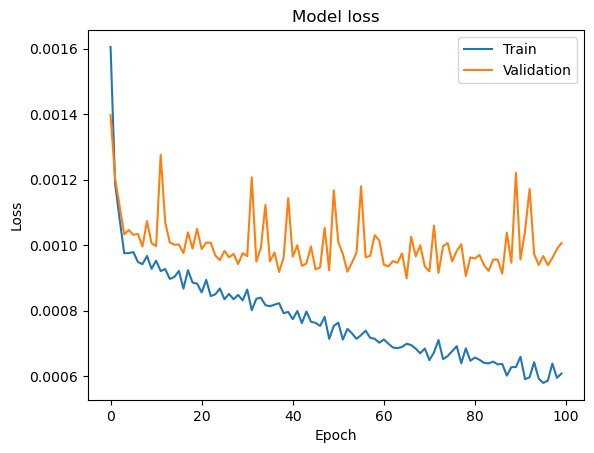

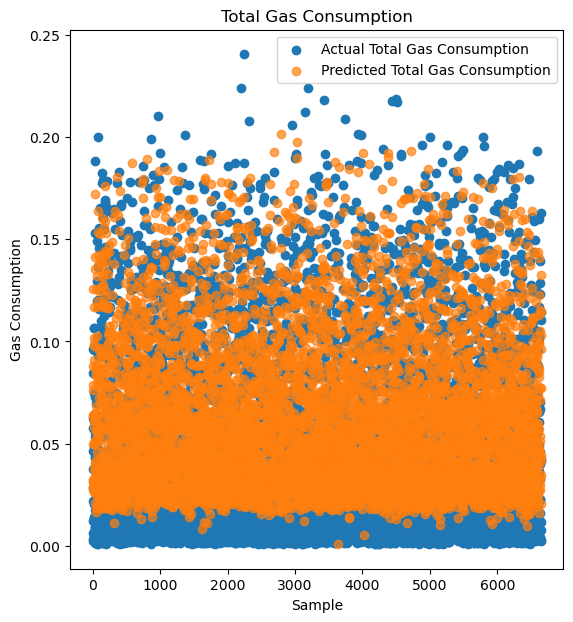

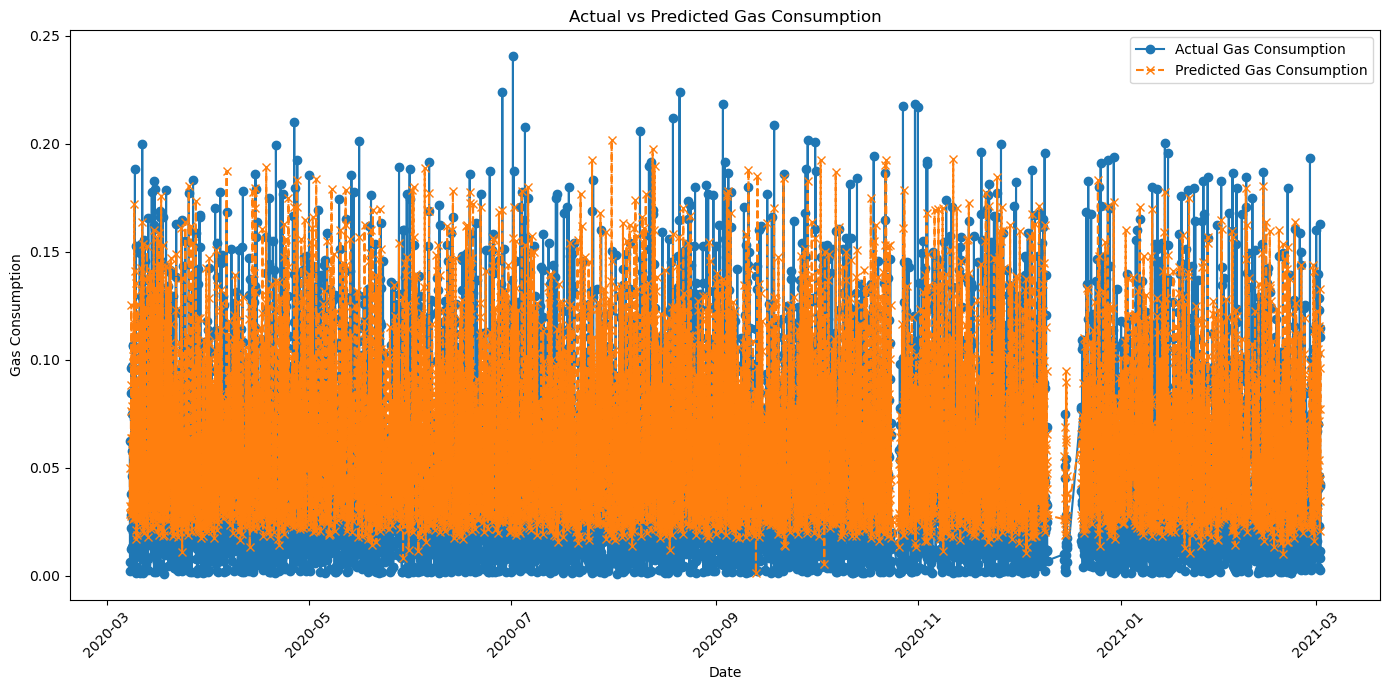

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the data
daily_stat = pd.read_csv('hourly_stat.csv').dropna()

# Ensure the date column is parsed as datetime
daily_stat['date'] = pd.to_datetime(daily_stat['date'])

# Extract features and target
features = daily_stat[['SH_temp_mean', 'SH_hum_mean', 'DWH_temp_mean', 'DWH_hum_mean', 'ext_temp_mean', 'ext_hum_mean']]
target = daily_stat['Gas_mean']

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data while keeping the date for plotting
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(features_scaled, target, daily_stat['date'], test_size=0.8, random_state=42)

# Ensure dates are sorted
date_test = pd.Series(date_test).sort_values().reset_index(drop=True)
date_train = pd.Series(date_train).sort_values().reset_index(drop=True)


# Reshape data for RNN input (samples, time steps, features)
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build RNN model
model = Sequential()
model.add(LSTM(192, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dense(8, activation='linear'))
model.add(Dense(4, activation='linear'))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Predict gas consumption on the test set
predictions = model.predict(X_test_rnn).flatten()

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')



# Plot training loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Compare actual vs predicted SH and DWH gas consumption
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, label='Actual Total Gas Consumption')
plt.scatter(range(len(y_test)), predictions, label='Predicted Total Gas Consumption', alpha=0.7)
plt.title('Total Gas Consumption')
plt.xlabel('Sample')
plt.ylabel('Gas Consumption')
plt.legend()

plt.show()

# Plot actual vs predicted gas consumption over time
plt.figure(figsize=(14, 7))
plt.plot(date_test, y_test, label='Actual Gas Consumption', marker='o')
plt.plot(date_test, predictions, label='Predicted Gas Consumption', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Gas Consumption')
plt.title('Actual vs Predicted Gas Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [14]:
import math

# Calculate evaluation metrics
mae_LSTM   = mean_absolute_error(y_test,  predictions)
mse_LSTM  = mean_squared_error(y_test,  predictions)
rmse_LSTM = math.sqrt(mse)
r2_LSTM  = r2_score(y_test,  predictions)
n = len(y_test)
p = X_test.shape[1]
adjusted_r2_LSTM  = 1 - (1 - r2) * (n - 1) / (n - p - 1)
mape_LSTM  = mean_absolute_percentage_error(y_test,  predictions)

print(f'Mean Squared Error (MSE): {mae_LSTM  }')
print(f'Root Mean Squared Error (RMSE): {mse_LSTM  }')
print(f'R-squared (R²): {r2_LSTM  }')
print(f'Adjusted R-squared (R²): {adjusted_r2_LSTM  }')

print(f'Mean Absolute Error (MAE): {mae_LSTM  }')
print(f'Mean Absolute Percentage Error (MAPE): {mape_LSTM  }%')

Mean Squared Error (MSE): 0.025333648310034488
Root Mean Squared Error (RMSE): 0.0010794194855037026
R-squared (R²): 0.45944696066368107
Adjusted R-squared (R²): 0.458958729708387
Mean Absolute Error (MAE): 0.025333648310034488
Mean Absolute Percentage Error (MAPE): 1.6518616354775046%


# SH

Epoch 1/100
42/42 [==============================] - 2s 10ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 11

42/42 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 84/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 85/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 86/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 87/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 88/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 89/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 90/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 91/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 92/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 93/100


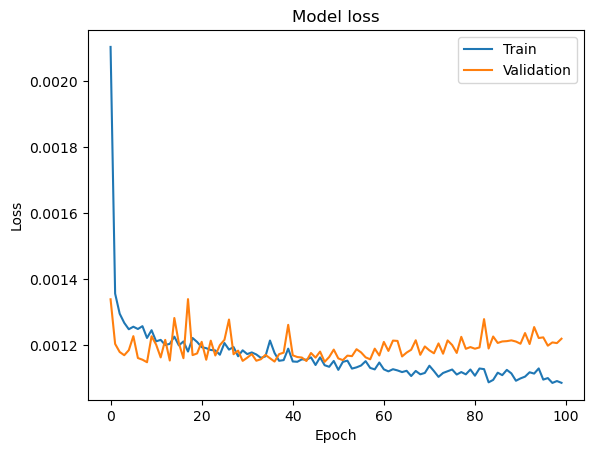

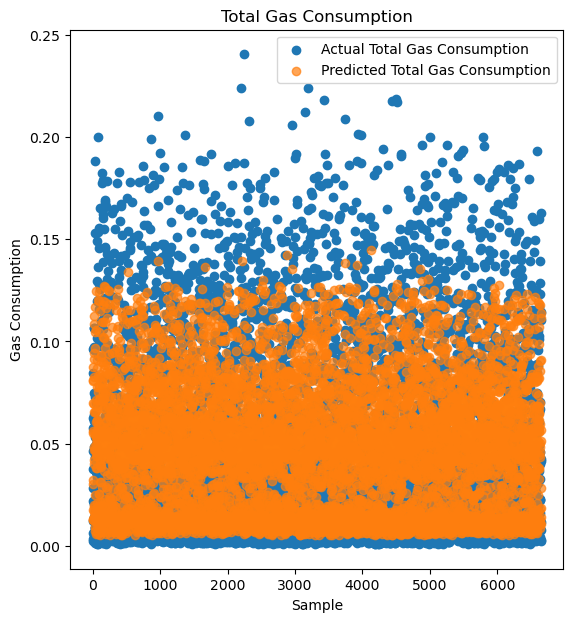

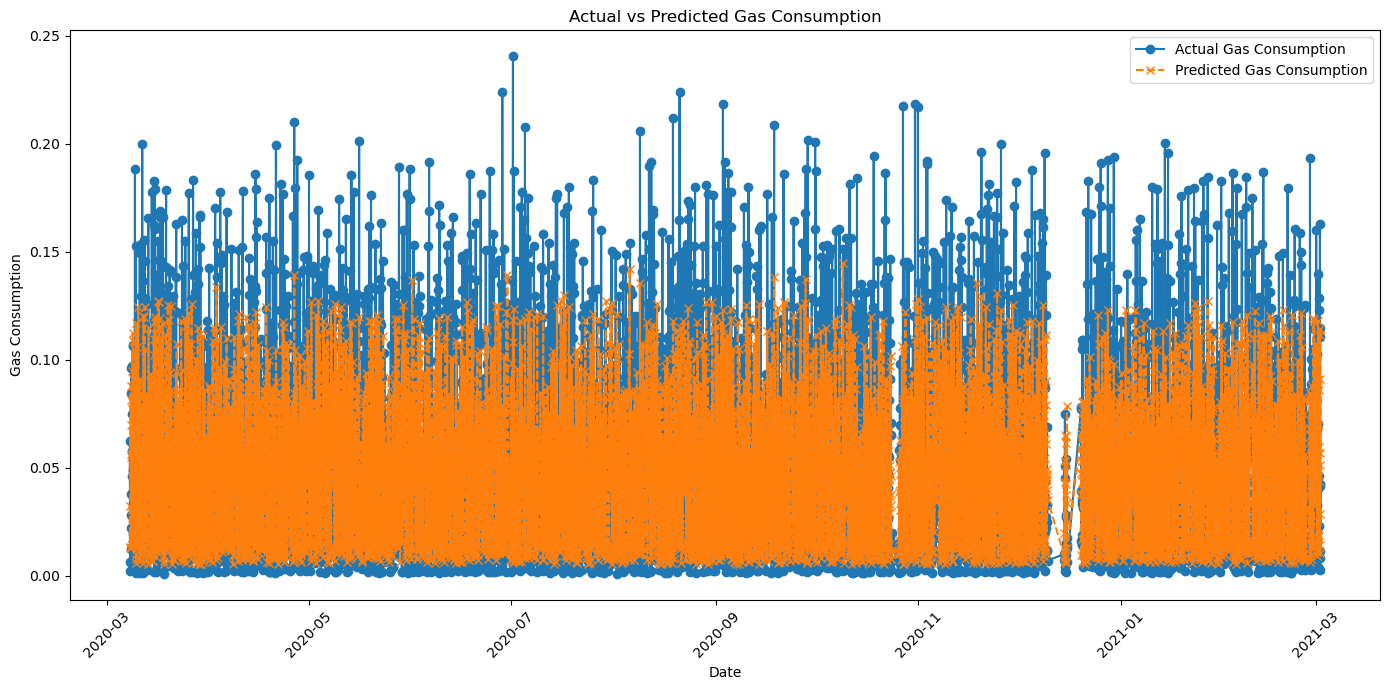

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the data
daily_stat = pd.read_csv('hourly_stat.csv').dropna()

# Ensure the date column is parsed as datetime
daily_stat['date'] = pd.to_datetime(daily_stat['date'])

# Extract features and target
features = daily_stat[['SH_temp_mean', 'SH_hum_mean']]
target = daily_stat['Gas_mean']

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data while keeping the date for plotting
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(features_scaled, target, daily_stat['date'], test_size=0.8, random_state=42)

# Ensure dates are sorted
date_test = pd.Series(date_test).sort_values().reset_index(drop=True)
date_train = pd.Series(date_train).sort_values().reset_index(drop=True)


# Reshape data for RNN input (samples, time steps, features)
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build RNN model
model = Sequential()
model.add(LSTM(192, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dense(8, activation='linear'))
model.add(Dense(4, activation='linear'))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Predict gas consumption on the test set
SH_predictions = model.predict(X_test_rnn).flatten()

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, SH_predictions)
mse = mean_squared_error(y_test, SH_predictions)
r2 = r2_score(y_test, SH_predictions)
mape = mean_absolute_percentage_error(y_test, SH_predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')



# Plot training loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Compare actual vs predicted SH and DWH gas consumption
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, label='Actual Total Gas Consumption')
plt.scatter(range(len(y_test)), SH_predictions, label='Predicted Total Gas Consumption', alpha=0.7)
plt.title('Total Gas Consumption')
plt.xlabel('Sample')
plt.ylabel('Gas Consumption')
plt.legend()

plt.show()

# Plot actual vs predicted gas consumption over time
plt.figure(figsize=(14, 7))
plt.plot(date_test, y_test, label='Actual Gas Consumption', marker='o')
plt.plot(date_test, SH_predictions, label='Predicted Gas Consumption', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Gas Consumption')
plt.title('Actual vs Predicted Gas Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [10]:
import math

# Calculate evaluation metrics
mae_LSTM_SH  = mean_absolute_error(y_test, SH_predictions)
mse_LSTM_SH = mean_squared_error(y_test, SH_predictions)
rmse_LSTM_SH= math.sqrt(mse)
r2_LSTM_SH = r2_score(y_test, SH_predictions)
n = len(y_test)
p = X_test.shape[1]
adjusted_r2_LSTM_SH = 1 - (1 - r2) * (n - 1) / (n - p - 1)
mape_LSTM_SH = mean_absolute_percentage_error(y_test, SH_predictions)

print(f'Mean Squared Error (MSE): {mae_LSTM_SH }')
print(f'Root Mean Squared Error (RMSE): {mse_LSTM_SH }')
print(f'R-squared (R²): {r2_LSTM_SH }')
print(f'Adjusted R-squared (R²): {adjusted_r2_LSTM_SH }')

print(f'Mean Absolute Error (MAE): {mae_LSTM_SH }')
print(f'Mean Absolute Percentage Error (MAPE): {mape_LSTM_SH }%')

Mean Squared Error (MSE): 0.025654243649237237
Root Mean Squared Error (RMSE): 0.0011993611175975612
R-squared (R²): 0.39938244020429803
Adjusted R-squared (R²): 0.3992017218171171
Mean Absolute Error (MAE): 0.025654243649237237
Mean Absolute Percentage Error (MAPE): 1.1080847105810814%


# DWH

Epoch 1/100
42/42 [==============================] - 3s 11ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 10/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 11

42/42 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 84/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 85/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 86/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 87/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 88/100
42/42 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 89/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 90/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 91/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 92/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 93/100


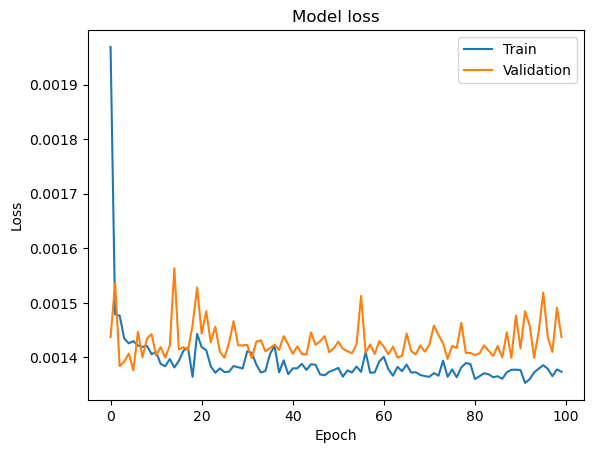

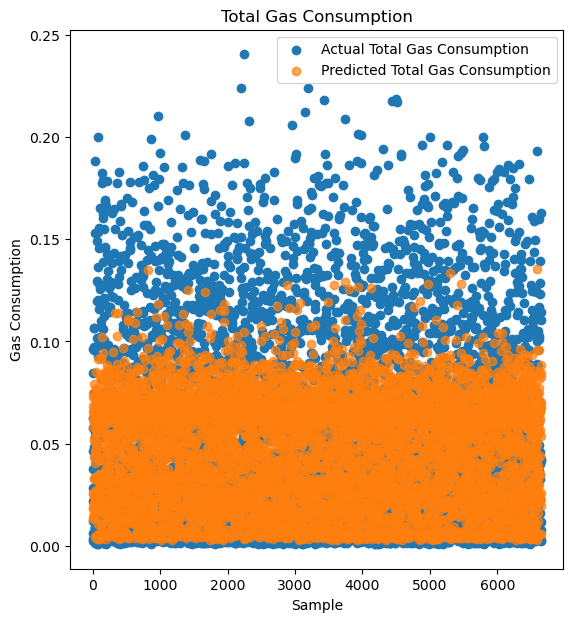

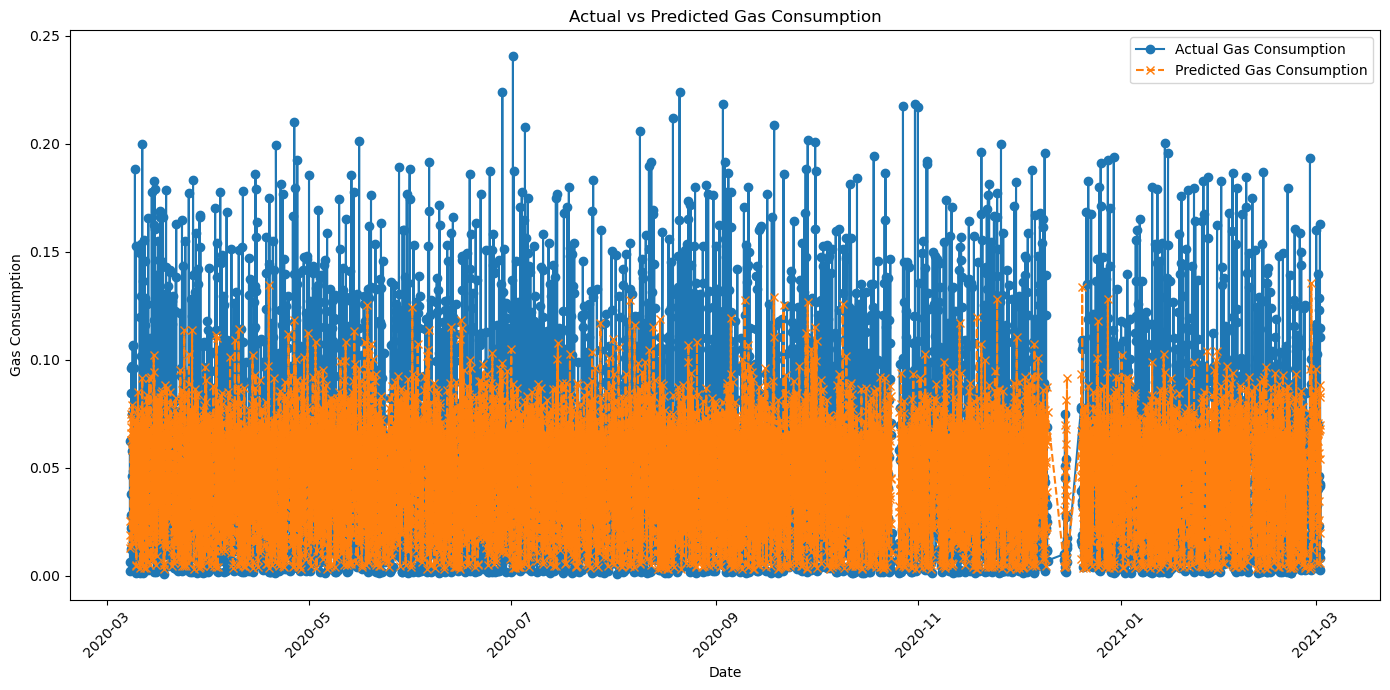

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load the data
daily_stat = pd.read_csv('hourly_stat.csv').dropna()

# Ensure the date column is parsed as datetime
daily_stat['date'] = pd.to_datetime(daily_stat['date'])

# Extract features and target
features = daily_stat[[ 'DWH_temp_mean', 'DWH_hum_mean']]
target = daily_stat['Gas_mean']

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split data while keeping the date for plotting
X_train, X_test, y_train, y_test, date_train, date_test = train_test_split(features_scaled, target, daily_stat['date'], test_size=0.8, random_state=42)

# Ensure dates are sorted
date_test = pd.Series(date_test).sort_values().reset_index(drop=True)
date_train = pd.Series(date_train).sort_values().reset_index(drop=True)


# Reshape data for RNN input (samples, time steps, features)
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build RNN model
model = Sequential()
model.add(LSTM(192, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dense(8, activation='linear'))
model.add(Dense(4, activation='linear'))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Predict gas consumption on the test set
DWH_predictions = model.predict(X_test_rnn).flatten()

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, DWH_predictions)
mse = mean_squared_error(y_test, DWH_predictions)
r2 = r2_score(y_test, DWH_predictions)
mape = mean_absolute_percentage_error(y_test, DWH_predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')



# Plot training loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Compare actual vs predicted SH and DWH gas consumption
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.scatter(range(len(y_test)), y_test, label='Actual Total Gas Consumption')
plt.scatter(range(len(y_test)), DWH_predictions, label='Predicted Total Gas Consumption', alpha=0.7)
plt.title('Total Gas Consumption')
plt.xlabel('Sample')
plt.ylabel('Gas Consumption')
plt.legend()

plt.show()

# Plot actual vs predicted gas consumption over time
plt.figure(figsize=(14, 7))
plt.plot(date_test, y_test, label='Actual Gas Consumption', marker='o')
plt.plot(date_test, DWH_predictions, label='Predicted Gas Consumption', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Gas Consumption')
plt.title('Actual vs Predicted Gas Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [8]:
import math

# Calculate evaluation metrics
mae_LSTM_DWH  = mean_absolute_error(y_test, DWH_predictions)
mse_LSTM_DWH = mean_squared_error(y_test, DWH_predictions)
rmse_LSTM_DWH= math.sqrt(mse)
r2_LSTM_DWH = r2_score(y_test, DWH_predictions)
n = len(y_test)
p = X_test.shape[1]
adjusted_r2_LSTM_DWH = 1 - (1 - r2) * (n - 1) / (n - p - 1)
mape_LSTM_DWH = mean_absolute_percentage_error(y_test, DWH_predictions)

print(f'Mean Squared Error (MSE): {mae_LSTM_DWH }')
print(f'Root Mean Squared Error (RMSE): {mse_LSTM_DWH }')
print(f'R-squared (R²): {r2_LSTM_DWH }')
print(f'Adjusted R-squared (R²): {adjusted_r2_LSTM_DWH }')

print(f'Mean Absolute Error (MAE): {mae_LSTM_DWH }')
print(f'Mean Absolute Percentage Error (MAPE): {mape_LSTM_DWH }%')

Mean Squared Error (MSE): 0.028522979256609845
Root Mean Squared Error (RMSE): 0.0014517487852978661
R-squared (R²): 0.2729914284627033
Adjusted R-squared (R²): 0.2727726805850029
Mean Absolute Error (MAE): 0.028522979256609845
Mean Absolute Percentage Error (MAPE): 1.3291794941314%


In [15]:
import pandas as pd

# Define the metrics for each category
metrics = ['MAE', 'MSE', 'RMSE', 'R2', 'Adjusted R2', 'MAPE']

# Define the values for each metric
LSTM_values = [mae_LSTM, mse_LSTM, rmse_LSTM, r2_LSTM, adjusted_r2_LSTM, mape_LSTM]
sh_values = [mae_LSTM_SH, mse_LSTM_SH, rmse_LSTM_SH, r2_LSTM_SH, adjusted_r2_LSTM_SH, mape_LSTM_SH]
dwh_values = [mae_LSTM_DWH, mse_LSTM_DWH, rmse_LSTM_DWH, r2_LSTM_DWH, adjusted_r2_LSTM_DWH, mape_LSTM_DWH]

# Create a dictionary to hold the data
data = {
    'Metric': metrics,
    'Total LSTM ': LSTM_values,
    'SH LSTM': sh_values,
    'DWH LSTM': dwh_values
}

# Create a DataFrame
df_metrics = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df_metrics.to_csv('LSTM_metrics.csv', index=False)

# Print the DataFrame to check
print(df_metrics)


        Metric  Total LSTM    SH LSTM  DWH LSTM
0          MAE     0.025334  0.025654  0.028523
1          MSE     0.001079  0.001199  0.001452
2         RMSE     0.032855  0.034632  0.038102
3           R2     0.459447  0.399382  0.272991
4  Adjusted R2     0.458959  0.399202  0.272773
5         MAPE     1.651862  1.108085  1.329179
